<h2> Music Genre Classification with RNN-LSTM Model: </h2>

In [1]:
import json
import librosa
import numpy as np
import tensorflow as tf

/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
DATA_PATH = "data.json"

def load_data(data_path = DATA_PATH):
  with open(data_path, "r") as fp:
    data = json.load(fp)

  mfcc = np.array(data["mfcc"])
  labels = np.array(data["labels"])
  return mfcc, labels

In [3]:
mfcc, labels = load_data(DATA_PATH)
delta_mfcc = librosa.feature.delta(mfcc, order = 1)
delta2_mfcc = librosa.feature.delta(mfcc, order = 2)

print(mfcc.shape)
print(delta_mfcc.shape)
print(delta2_mfcc.shape)

(9989, 132, 13)
(9989, 132, 13)
(9989, 132, 13)


In [4]:
from sklearn.model_selection import train_test_split

def split_data(features, labels):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.30, random_state = 42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42)
  return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(np.stack([mfcc, delta_mfcc, delta2_mfcc], axis = -1), labels)

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

(132, 13, 3)


In [5]:
import tensorflow.keras as keras

lstm_model = keras.Sequential()

lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters = 32, kernel_size = 3, activation = 'relu'), 
                                  input_shape = input_shape))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.BatchNormalization()))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters = 64, kernel_size = 3, activation='relu')))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.BatchNormalization()))
lstm_model.add(keras.layers.TimeDistributed(keras.layers.Flatten()))

lstm_model.add(keras.layers.LSTM(64, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))
lstm_model.add(keras.layers.GRU(128, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.3))
lstm_model.add(keras.layers.LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))

lstm_model.add(keras.layers.Dense(256, activation = 'relu'))
lstm_model.add(keras.layers.Dropout(0.4))
lstm_model.add(keras.layers.Dense(128, activation = 'relu'))
lstm_model.add(keras.layers.Dropout(0.4))

lstm_model.add(keras.layers.Dense(10, activation = 'softmax'))

lstm_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

lstm_model.summary()

/Users/xenexjoshi/Music Genre Classification/.venv/lib/python3.9/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 132, 11, 32)    │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 132, 11, 32)    │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 132, 9, 64)     │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 132, 9, 64)     │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 132, 576)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 132, 64)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 132, 128)       │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,298 (1.69 MB)

 Trainable params: 444,106 (1.69 MB)

 Non-trainable params: 192 (768.00 B)

In [6]:
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

In [7]:
history = lstm_model.fit(X_train, y_train, 
                        validation_data = (X_validation, y_validation),
                        batch_size = 32,
                        epochs = 20,
                        callbacks = [early_stopping, reduce_lr])

Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 201s 943ms/step - accuracy: 0.2508 - loss: 2.0593 - val_accuracy: 0.4099 - val_loss: 1.6341 - learning_rate: 0.0010
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 168s 902ms/step - accuracy: 0.3862 - loss: 1.7019 - val_accuracy: 0.4909 - val_loss: 1.4864 - learning_rate: 0.0010
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 167s 900ms/step - accuracy: 0.4485 - loss: 1.5573 - val_accuracy: 0.4747 - val_loss: 1.4183 - learning_rate: 0.0010
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 174s 933ms/step - accuracy: 0.4964 - loss: 1.4335 - val_accuracy: 0.5367 - val_loss: 1.3175 - learning_rate: 0.0010
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5054 - loss: 1.3839 - val_accuracy: 0.5739 - val_loss: 1.1887 - learning_rate: 0.0010
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.5697 - loss: 1.2451 - val_accuracy: 0.5806 - val_loss: 1.1288 - learning_rate: 0.0010
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 183s 984ms/step - accuracy: 0.

In [10]:
_, accuracy = lstm_model.evaluate(X_test, y_test)
print("Model accuracy: " + str(round(100 * accuracy, 3)) + "%.")

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7417 - loss: 0.7639
Model accuracy: 73.674%.


<h3> Analysis: </h3>

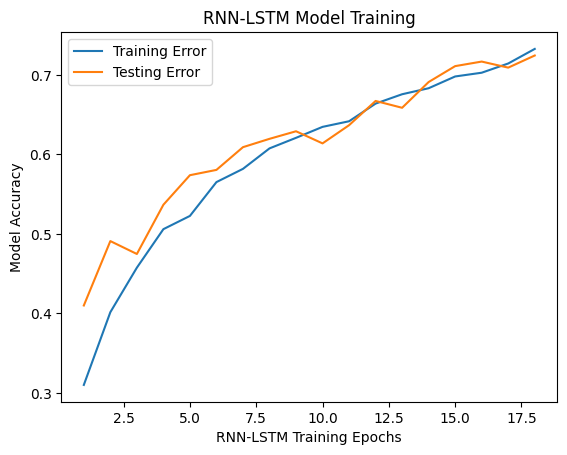

In [12]:
import matplotlib.pyplot as plt

x_range = range(1, 21)
plt.plot(x_range, history.history['accuracy'], label = 'Training Error')
plt.plot(x_range, history.history['val_accuracy'], label = 'Testing Error')
plt.xlabel('RNN-LSTM Training Epochs')
plt.ylabel('Model Accuracy')
plt.title('RNN-LSTM Model Training')
plt.legend()
plt.show()